__1. взять любой набор данных для бинарной классификации__

Набор данных: Heart Disease Data Set (https://archive.ics.uci.edu/ml/datasets/Heart+Disease)

Анализ наличия сердечно-сосудитстых заболеваний.

__2. сделать обзорный анализ выбранного датасета__

In [21]:
import re
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

1. age - age in years <br>
2. sex - (1 = male; 0 = female) <br>
3. chest pain type (4 values) <br>
4. resting blood pressure - in mm Hg on admission to the hospital
5. serum cholestoral in mg/dl <br>
6. fasting blood sugar > 120 mg/dl - 1 = true; 0 = false <br>
7. resting electrocardiographic results - values 0,1,2 <br>
8. maximum heart rate achieved <br>
9. exercise induced angina - (1 = yes; 0 = no) <br>
10. oldpeak = ST depression induced by exercise relative to rest
11. the slope of the peak exercise ST segment <br>
12. ca - number of major vessels (0-3) colored by flourosopy <br>
13. thal - 3 = normal; 6 = fixed defect; 7 = reversable defect 

In [30]:
df = pd.read_csv('heart.csv')
df.describe()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
count,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000
mean,54.366337,0.683168,0.966997,131.623762,246.264026,0.148515,0.528053,149.646865,0.326733,1.039604,1.399340,0.729373,2.313531,0.544554
std,9.082101,0.466011,1.032052,17.538143,51.830751,0.356198,0.525860,22.905161,0.469794,1.161075,0.616226,1.022606,0.612277,0.498835
min,29.000000,0.000000,0.000000,94.000000,126.000000,0.000000,0.000000,71.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,47.500000,0.000000,0.000000,120.000000,211.000000,0.000000,0.000000,133.500000,0.000000,0.000000,1.000000,0.000000,2.000000,0.000000
50%,55.000000,1.000000,1.000000,130.000000,240.000000,0.000000,1.000000,153.000000,0.000000,0.800000,1.000000,0.000000,2.000000,1.000000
75%,61.000000,1.000000,2.000000,140.000000,274.500000,0.000000,1.000000,166.000000,1.000000,1.600000,2.000000,1.000000,3.000000,1.000000
max,77.000000,1.000000,3.000000,200.000000,564.000000,1.000000,2.000000,202.000000,1.000000,6.200000,2.000000,4.000000,3.000000,1.000000


In [33]:
# Проверка пропусков

pd.DataFrame([df.isna().sum(), df.isnull().sum()], index={'na', 'null'})

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
na,0,0,0,0,0,0,0,0,0,0,0,0,0,0
null,0,0,0,0,0,0,0,0,0,0,0,0,0,0


Пропусков нет.

In [27]:
# Проверка дубликатов

df.duplicated(keep=False).value_counts()

False    301
True       2
dtype: int64

In [34]:
df.loc[df['age'] <= 20, 'age'] = 1
df.loc[(df['age'] > 20) & (df['age'] <= 35), 'age'] = 2
df.loc[(df['age'] > 35) & (df['age'] <= 50), 'age'] = 3
df.loc[(df['age'] > 50) & (df['age'] <= 65), 'age'] = 4 
df.loc[(df['age'] > 65) & (df['age'] <= 80), 'age'] = 5 
df.loc[df['age'] >= 80, 'age'] = 6
df['age'].value_counts()

4    175
3     88
5     33
2      7
Name: age, dtype: int64

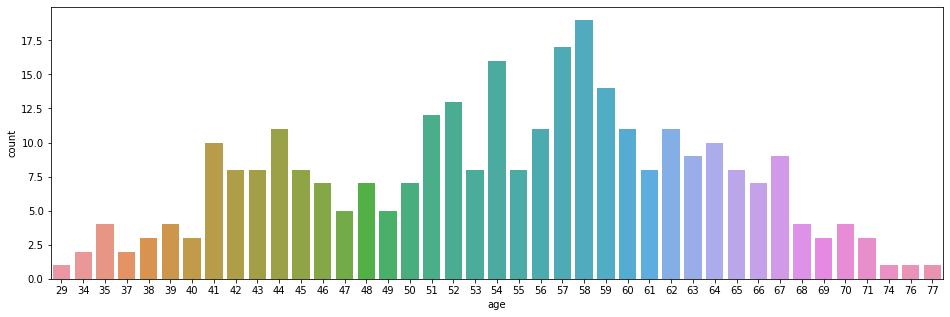

In [31]:
plt.figure(figsize=(16, 5))
sns.countplot(data=df, x='age');

До 20 лет - никого. Группа риска - от 50 до 65 лет. А после 80 лет нет данных.

In [35]:
# Аналитика по давлению

cat_1 = len(df.loc[df['trestbps'] < 100])  #гипотония
cat_2 = len(df.loc[(df['trestbps'] >= 100) & (df['trestbps'] < 130)]) #норма
cat_3 = len(df.loc[(df['trestbps'] >= 130) & (df['trestbps'] < 140)]) #повышенное
cat_4 = len(df.loc[(df['trestbps'] >= 140) & (df['trestbps'] < 160)])  #гипертония 1 степени
cat_5 = len(df.loc[(df['trestbps'] >= 160) & (df['trestbps'] < 180)])  #гипертония 2 степени
cat_6 = len(df.loc[df['trestbps'] >= 180])  #гипертония 3 степени

df.loc[df['trestbps'] < 100, 'trestbps'] = 1 
df.loc[(df['trestbps'] >= 100) & (df['trestbps'] < 130), 'trestbps'] = 2
df.loc[(df['trestbps'] >= 130) & (df['trestbps'] < 140), 'trestbps'] = 3
df.loc[(df['trestbps'] >= 140) & (df['trestbps'] < 160), 'trestbps'] = 4
df.loc[(df['trestbps'] >= 160) & (df['trestbps'] < 180), 'trestbps'] = 5
df.loc[df['trestbps'] >= 180, 'trestbps'] = 6
df['trestbps'].value_counts()

2    133
4     71
3     71
5     21
6      5
1      2
Name: trestbps, dtype: int64

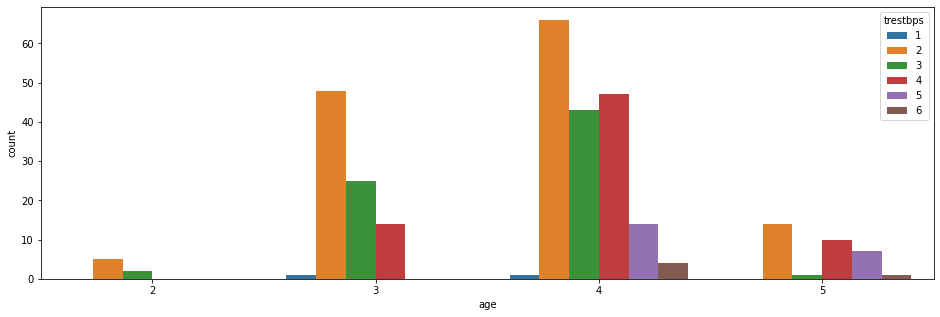

In [38]:
plt.figure(figsize=(16, 5))
sns.countplot(data=df, x='age', hue='trestbps');

То же самое по давлению

In [36]:
# Холестирин

df.loc[df['chol'] < 200, 'chol'] = 1 # желательный 
df.loc[(df['chol'] >= 200) & (df['chol'] < 240), 'chol'] = 2 #  пограничный
df.loc[df['chol'] >= 240, 'chol'] = 3 #  высокий
df['chol'].value_counts()

3    155
2     98
1     50
Name: chol, dtype: int64

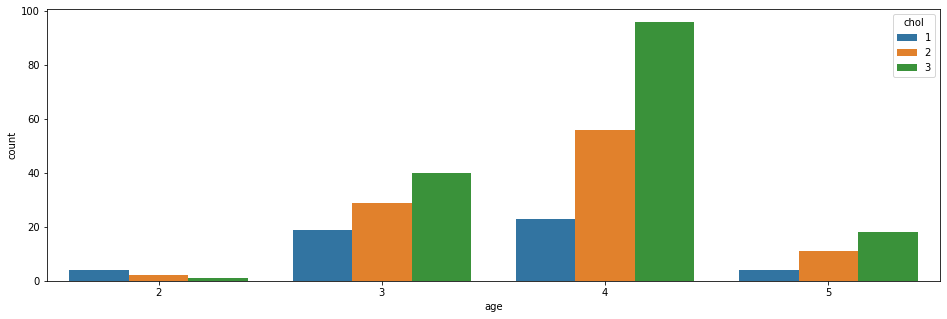

In [39]:
plt.figure(figsize=(16, 5))
sns.countplot(data=df, x='age', hue='chol');

То же самое по холестирину. По всем пунктам Никаких противоречий с общеизвестными фактами

__3. сделать feature engineering__

In [41]:
# Разбиваем выборку на тренировочную и тестовую части и обучаем модель.

from sklearn.model_selection import train_test_split

x_data = df.iloc[:,:-1]
y_data = df.iloc[:,-1]

x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.2, random_state=7)

__4. обучить любой классификатор (какой вам нравится)__

In [43]:
%%time
import xgboost as xgb

model = xgb.XGBClassifier()
model.fit(x_train, y_train)
y_predict = model.predict(x_test)

CPU times: user 42.4 ms, sys: 17 ms, total: 59.4 ms
Wall time: 172 ms


In [44]:
# Проверка качества модели

def evaluate_results(y_test, y_predict):
    
    from sklearn.metrics import recall_score, precision_score, f1_score, roc_auc_score

    return pd.DataFrame(
        [{
            'f1': f1_score(y_test, y_predict),
            'precision': precision_score(y_test, y_predict, average='binary'),
            'recall': recall_score(y_test, y_predict, average='binary'),
            'roc': roc_auc_score(y_test, y_predict),
        }],
        index={'metrics'}).round(3)


evaluate_results(y_test, y_predict)

,f1,precision,recall,roc
metrics,0.754,0.684,0.839,0.719


__5. разобраться с SHAP и построить важности признаков для:__

In [47]:
#pip install shap

In [72]:
import xgboost
import shap

from sklearn.pipeline import Pipeline, make_pipeline, FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin
import itertools
shap.initjs()

In [54]:
%%time

model = xgboost.train({"learning_rate": 0.01}, 
                      xgboost.DMatrix(x_data, label=y_data), 100)

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(x_data)

shap.force_plot(explainer.expected_value, shap_values[0,:], x_data.iloc[0,:])

CPU times: user 491 ms, sys: 903 µs, total: 492 ms
Wall time: 498 ms


__- всего тестового набора данных (summary_plot - дать интерпретацию)__

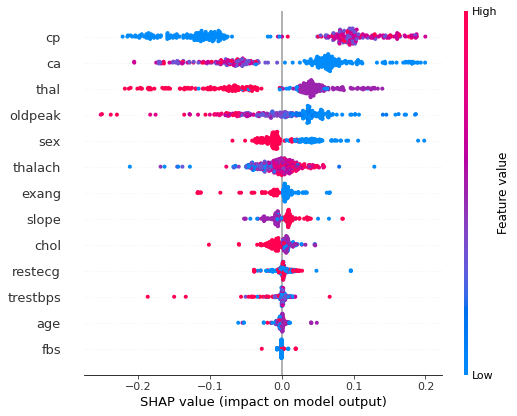

In [55]:
shap.summary_plot(shap_values, x_data)

Удивительно, что уровень холестирина (chol) не такой уж верный признак вероятных проблем с сердцем, а вот боли в груди, не связанные с простудными заболеваниями (cp), количество крупных сосудов (0-3), окрашенных флурозопией (ca) и достигнутая максимальная частота сердечных сокращений во время нагрузки (thal) точно могут быть в помощь диагносту

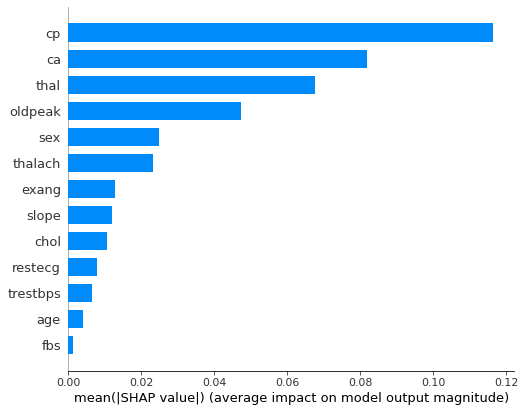

In [56]:
# Cредние значения SHAP для каждого признака

shap.summary_plot(shap_values, x_data, plot_type="bar")

__- для топ 10%__ (не "докрутил")

In [86]:
preds = model.predict(xgboost.DMatrix(x_data))
x_data['sex'] = preds
x_data_sorted = x_data.sort_values(by='sex', ascending=False)
x_data_10 = x_data_sorted.head(int(x_data.shape[0] * .1)).drop(['sex'], axis = 1)
shap_values = explainer.shap_values(x_data_10)

shap.summary_plot(shap_values, x_data_10)

ValueError: ignored

__6. для отдельных наблюдений вывести force_plot и попытаться проинтерпретировать результат__

In [74]:
def force_plot(sample_number):
    display(
        pd.DataFrame(df.iloc[sample_number, :]).T,
        shap.force_plot(explainer.expected_value, shap_values[sample_number, :], x_train.iloc[sample_number, :]))

shap.initjs()
force_plot(sample_number=100)

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
100,3.0,1.0,3.0,4.0,3.0,0.0,0.0,178.0,0.0,0.8,2.0,2.0,2.0,1.0


Человеку под номером 100 пора к врачу, т.к. его сердечный ритм и боли в груди находятся в пограничных зонах.